<a href="https://colab.research.google.com/github/mateus558/INPE-BDQueimadas-Analise-dados/blob/master/inpe_queimadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Focos de incêndio no Brasil INPE (2017 - 2020)

## Importando Bibliotecas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

## Carregamento dos dados

In [ ]:
data_folder = '/content/drive/My Drive/data/queimadas/'
periods = [2017,2018,2019,2020]
sheets = [data_folder + f"Focos_{year}_{year+1}.csv" for year in periods]
print(sheets)

['/content/drive/My Drive/data/queimadas/Focos_2017_2018.csv', '/content/drive/My Drive/data/queimadas/Focos_2018_2019.csv', '/content/drive/My Drive/data/queimadas/Focos_2019_2020.csv', '/content/drive/My Drive/data/queimadas/Focos_2020_2021.csv']


In [ ]:
columns = ['datahora', 'estado', 'municipio', 'bioma', 'diasemchuva', 'precipitacao', 'riscofogo', 'latitude', 'longitude', 'frp']
 
dfs = [pd.read_csv(sheet, usecols=columns, dtype={columns[1]: 'category', columns[2]: 'category', columns[3]: 'category'}) for sheet in sheets]
df = pd.concat(dfs)
dfs.clear()
 
df.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11953450 entries, 0 to 3235465
Columns: 10 entries, datahora to frp
dtypes: category(1), float64(6), object(3)
memory usage: 3.0 GB


In [ ]:
df.head()

,datahora,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
0,2017/08/18 01:06:19,GOIAS,SAO MIGUEL DO ARAGUAIA,Cerrado,0.0,0.0,1.0,-12.9982,-50.5719,NaN
1,2017/09/04 04:41:00,GOIAS,BALIZA,Cerrado,0.0,0.0,1.0,-16.4518,-52.6167,NaN
2,2017/09/02 10:53:17,GOIAS,JUSSARA,Cerrado,0.0,0.0,1.0,-15.1741,-51.6476,NaN
3,2017/09/03 17:33:00,GOIAS,SAO MIGUEL DO ARAGUAIA,Cerrado,0.0,0.0,1.0,-13.0006,-50.5713,NaN
4,2017/09/05 16:55:00,GOIAS,BRITANIA,Cerrado,0.0,0.0,1.0,-14.9489,-51.1452,NaN


In [ ]:
df.describe()

,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
count,1.184102e+07,1.184102e+07,1.184102e+07,1.195345e+07,1.195345e+07,4.241007e+06
mean,1.664759e+01,5.801490e-01,-6.817208e+00,-1.038915e+01,-5.242054e+01,2.012194e+01
std,6.961477e+01,2.814563e+00,8.699332e+01,5.920152e+00,6.979126e+00,5.821204e+01
min,-9.990000e+02,0.000000e+00,-9.990000e+02,-3.371330e+01,-7.391000e+01,0.000000e+00
25%,0.000000e+00,0.000000e+00,7.000000e-01,-1.385260e+01,-5.709350e+01,3.500000e+00
50%,6.000000e+00,0.000000e+00,1.000000e+00,-9.542800e+00,-5.181500e+01,7.700000e+00
75%,2.600000e+01,0.000000e+00,1.000000e+00,-6.501000e+00,-4.719880e+01,1.790000e+01
max,1.200000e+02,1.572000e+02,1.000000e+00,5.194400e+00,-3.480180e+01,8.589800e+03


## Pré-processamento dos dados


In [ ]:
cat_columns = ['ano', 'mes', 'dia', 'horario', 'estado', 'municipio', 'bioma']
num_columns = ['diasemchuva', 'precipitacao', 'riscofogo', 'latitude', 'longitude', 'frp']
 
def process_datehour(df):
    df[["data", "hora"]] = df.datahora.str.split(" ", expand=True,)
    df = df.drop("datahora", axis=1)
    df[["ano", "mes", "dia"]] = df.data.str.split("/", expand=True,)
    df['ano'] = df['ano'].astype('int16')
    df[["mes", "dia"]] = df[["mes", "dia"]].astype('int8')
    df = df.drop("data", axis=1)
    df[["hora", "min", "s"]] = df.hora.str.split(":", expand=True,).astype("int8")
    df = df.drop(['min', 's'], axis=1)
    df['hora'] = df['hora'].astype("int8")
    df['horario'] = pd.cut(df.hora, bins=[-1,6,12,18,23,np.inf], labels=False, right=True) + 1
    df['horario'] = df['horario'].astype("int8")
    df = df.drop('hora', axis=1)
    return df

In [ ]:
df[cat_columns[4:]] = df[cat_columns[4:]].astype('category')
estados = df['estado'].cat.categories
municipios = df['municipio'].cat.categories
biomas = df['bioma'].cat.categories
 
for i in range(4, len(cat_columns)-1):
  df[cat_columns[i]] = df[cat_columns[i]].cat.codes

print(f'Estados ({len(estados)}): {estados}\nMunicipios ({len(municipios)}): {municipios}\nBiomas ({len(biomas)}): {biomas}')

Estados (48): Index(['ACRE', 'ALAGOAS', 'AMAPA', 'AMAZONAS', 'Alagoas', 'Amapa', 'Amazonas',
       'BAHIA', 'Bahia', 'CEARA', 'Ceara', 'DISTRITO FEDERAL',
       'ESPIRITO SANTO', 'GOIAS', 'Goias', 'MARANHAO', 'MATO GROSSO',
       'MATO GROSSO DO SUL', 'MINAS GERAIS', 'Maranhao', 'Mato Grosso',
       'Mato Grosso do Sul', 'Minas Gerais', 'PARA', 'PARAIBA', 'PARANA',
       'PERNAMBUCO', 'PIAUI', 'Para', 'Paraiba', 'Parana', 'Pernambuco',
       'Piaui', 'RIO DE JANEIRO', 'RIO GRANDE DO NORTE', 'RIO GRANDE DO SUL',
       'RONDONIA', 'RORAIMA', 'Rio Grande do Norte', 'Rio Grande do Sul',
       'Roraima', 'SANTA CATARINA', 'SAO PAULO', 'SERGIPE', 'Santa Catarina',
       'Sergipe', 'TOCANTINS', 'Tocantins'],
      dtype='object')
Municipios (5559): Index(['ABADIA DE GOIAS', 'ABADIA DOS DOURADOS', 'ABADIANIA', 'ABAETE',
       'ABAETETUBA', 'ABAIARA', 'ABAIRA', 'ABARE', 'ABATIA', 'ABDON BATISTA',
       ...
       'XAXIM', 'XEXEU', 'XINGUARA', 'XIQUE-XIQUE', 'Xaxim', 'ZABELE',
       

In [ ]:
df.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11953450 entries, 0 to 3235465
Columns: 10 entries, datahora to frp
dtypes: category(1), float64(6), int16(1), int8(1), object(1)
memory usage: 1.5 GB


In [ ]:
df.head()

,datahora,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
0,2017/08/18 01:06:19,13,4800,Cerrado,0.0,0.0,1.0,-12.9982,-50.5719,NaN
1,2017/09/04 04:41:00,13,469,Cerrado,0.0,0.0,1.0,-16.4518,-52.6167,NaN
2,2017/09/02 10:53:17,13,2657,Cerrado,0.0,0.0,1.0,-15.1741,-51.6476,NaN
3,2017/09/03 17:33:00,13,4800,Cerrado,0.0,0.0,1.0,-13.0006,-50.5713,NaN
4,2017/09/05 16:55:00,13,756,Cerrado,0.0,0.0,1.0,-14.9489,-51.1452,NaN


In [ ]:
df = process_datehour(df)
df.sort_values(by=['ano', 'mes', 'dia', 'horario'], inplace = True) 
df = df[cat_columns+num_columns]
df.dtypes

ano                int16
mes                 int8
dia                 int8
horario             int8
estado              int8
municipio          int16
bioma           category
diasemchuva      float64
precipitacao     float64
riscofogo        float64
latitude         float64
longitude        float64
frp              float64
dtype: object

In [ ]:
df.head()

,ano,mes,dia,horario,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
45,2017,1,1,1,9,278,Caatinga,0.0,0.3,1.0,-4.0034,-38.2318,NaN
17778,2017,1,1,1,7,95,Mata Atlantica,0.0,0.0,1.0,-17.4986,-39.4653,NaN
17801,2017,1,1,1,12,4944,Mata Atlantica,0.0,0.0,-999.0,-20.2310,-40.2177,NaN
17802,2017,1,1,1,7,95,Mata Atlantica,0.0,0.0,1.0,-17.4967,-39.4558,NaN
17804,2017,1,1,1,7,1708,Mata Atlantica,0.0,0.4,1.0,-11.8212,-37.9710,NaN


In [ ]:
df.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11953450 entries, 45 to 3213345
Columns: 13 entries, ano to frp
dtypes: category(1), float64(6), int16(2), int8(4)
memory usage: 741.0 MB


## Análise dos Dados

In [ ]:
focos_ano = df.groupby(['ano'])['bioma'].value_counts()
focos_ano

ano   bioma         
2017  Amazonia          1434113
      Cerrado           1061276
      Mata Atlantica     158605
      Caatinga           126315
      Pantanal            76181
      Pampa                7777
2018  Amazonia           919426
      Cerrado            604778
      Caatinga           140928
      Mata Atlantica     116394
      Pantanal            21921
      Pampa                6466
2019  Amazonia          1810714
      Cerrado           1406306
      Mata Atlantica     290481
      Caatinga           288140
      Pantanal           230305
      Pampa               16342
2020  Amazonia          1608474
      Cerrado            875929
      Pantanal           495468
      Mata Atlantica     166540
      Caatinga            72945
      Pampa               16659
Name: bioma, dtype: int64

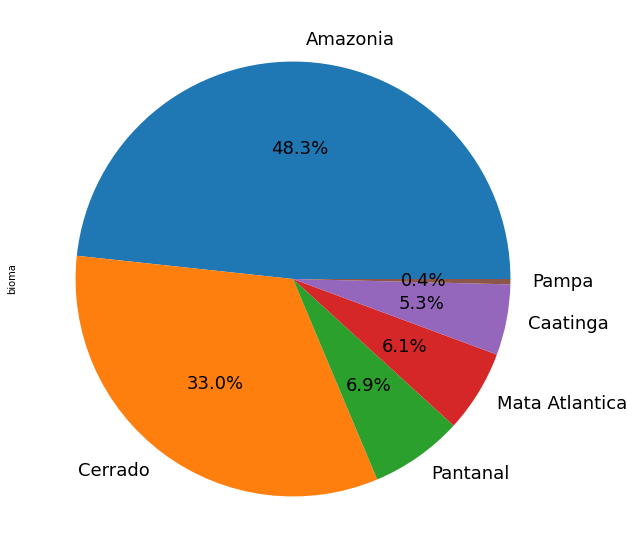

In [ ]:
plot = df['bioma'].value_counts().plot.pie(y='bioma', figsize=(10, 10), autopct='%1.1f%%', fontsize=18)
#plot.set_title("Focos de fogo de 2017 até setembro de 2020", fontsize=15)

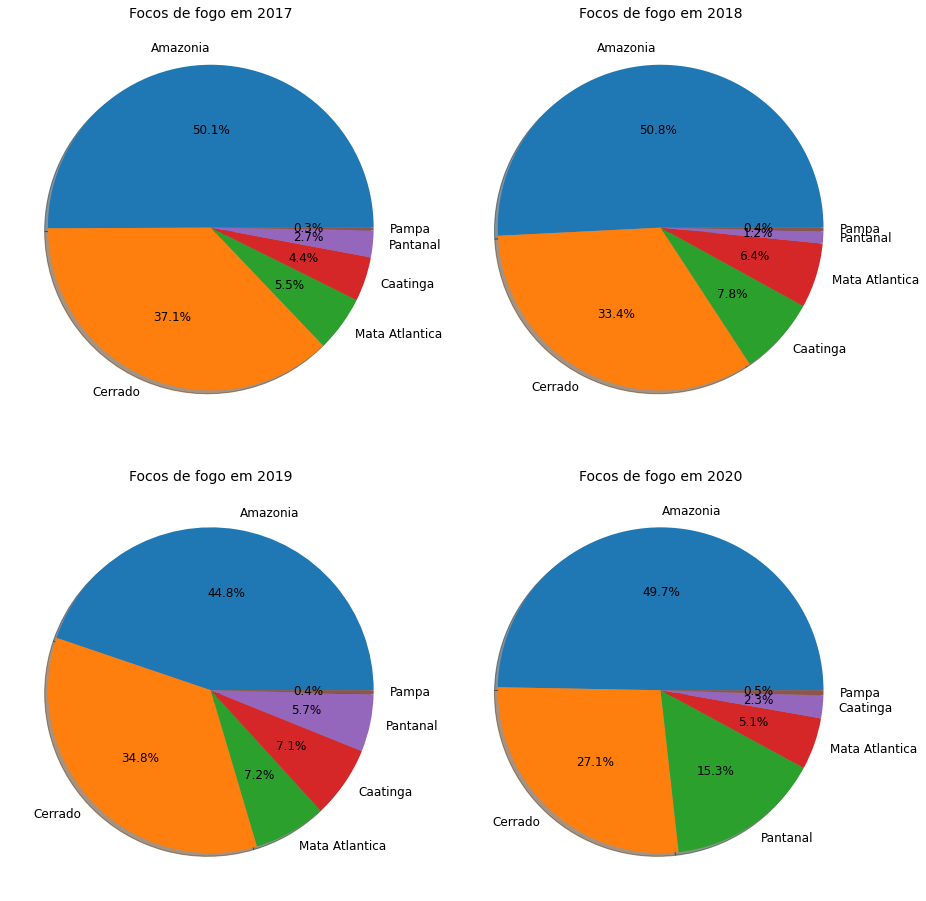

In [ ]:
fig, axs  = plt.subplots(2, int(len(periods)/2), figsize=(13,13))
j = 0
k = 0

for i in range(len(periods)):
  labels = focos_ano[periods[i]].keys()
  axs[k][j].pie(focos_ano[periods[i]], labels=labels, radius=1, autopct='%1.1f%%', shadow=True, textprops={'fontsize': 12})
  axs[k][j].set_title("Focos de fogo em " + str(periods[i]), fontsize=14)
  
  j += 1
  if j % 2 == 0:
    k += 1
    j = 0

plt.tight_layout()
plt.show()

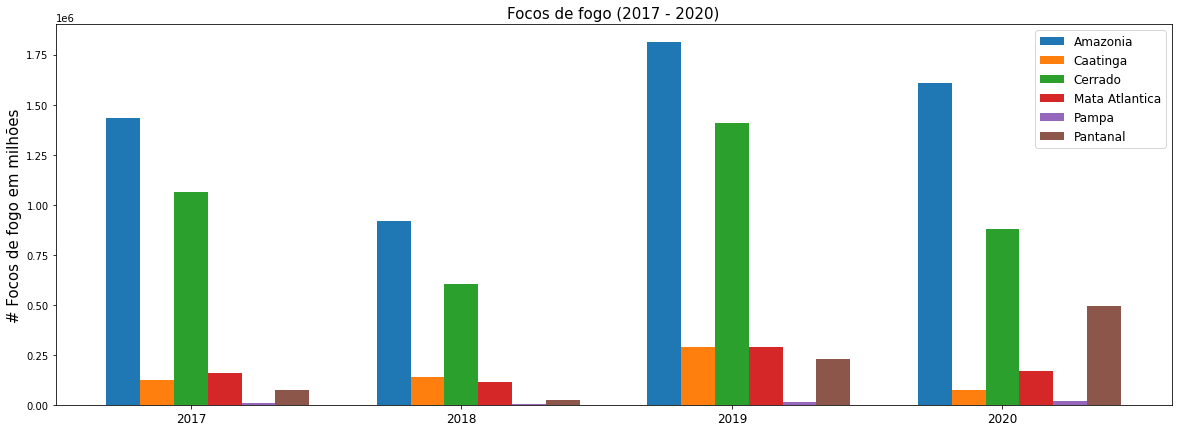

In [ ]:
x = []
y = {}
for key, grp in df.groupby('ano'):
  x.append(key)
  count = grp['bioma'].value_counts()
  for grp_key in count.keys():
    if grp_key not in y:
      y[grp_key] = [count[grp_key]]
    else:
      y[grp_key].append(count[grp_key])

fig, ax = plt.subplots(figsize=(20,7))  # sets the window to 8 x 6 inches
width = 0.125

xloc = np.arange(len(x))  # the label locations
tmp_wid = 0
for bioma in biomas:
  ax.bar(xloc+tmp_wid, y[bioma], width, label=bioma)
  tmp_wid += width

ax.set_title(f"Focos de fogo ({x[0]} - {x[-1]})", fontsize=15)
ax.set_ylabel('# Focos de fogo em milhões', fontsize=15)
xloc_offset = ((len(biomas)/2) - 1) * width
ax.set_xticks([loc + xloc_offset for loc in xloc])
ax.set_xticklabels([str(year) for year in x], fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [ ]:
def plot_year(_df, year):
  df = _df[_df['ano'] == year]
  x_ticks = ['Janeiro', 'Fevereivo', 'Março', 'Abril', 'Maio', 'Junho', 'Julho',
             'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
  x = []
  y = {}
  for key, grp in df.groupby('mes'):
    x.append(key)
    count = grp['bioma'].value_counts()
    for grp_key in count.keys():
      if grp_key not in y:
        y[grp_key] = [count[grp_key]]
      else:
        y[grp_key].append(count[grp_key])

  fig = plt.figure(figsize=(15,10))

  for bioma in biomas:
    plt.plot(x, y[bioma], label=bioma)

  plt.title(f"Focos de fogo em {year}", fontsize=15)
  plt.ylabel('# Focos de fogo', fontsize=15)
  plt.xticks(x, x_ticks, fontsize=12)
  plt.yticks(fontsize=12)
  plt.legend(fontsize=12)
  plt.show()

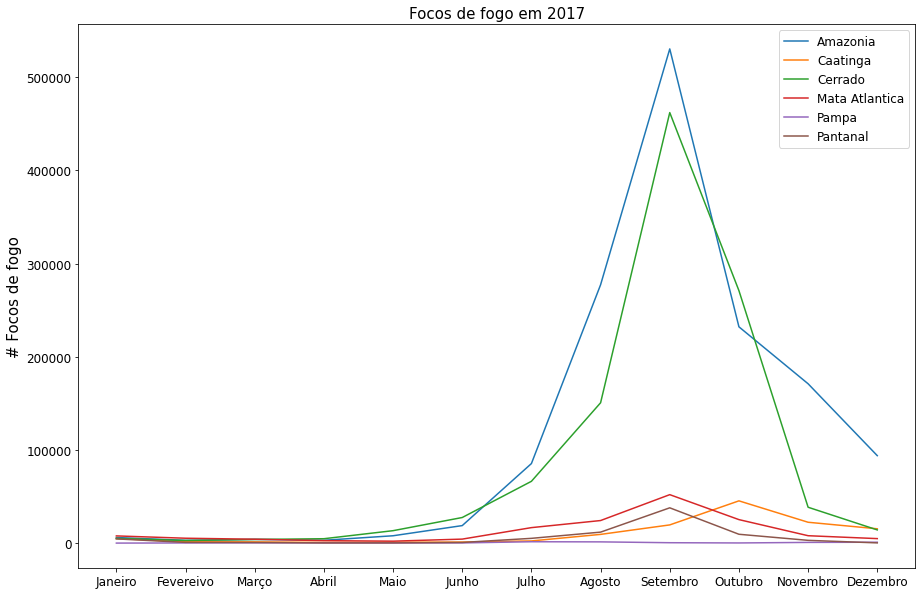

In [ ]:
plot_year(df, 2017)

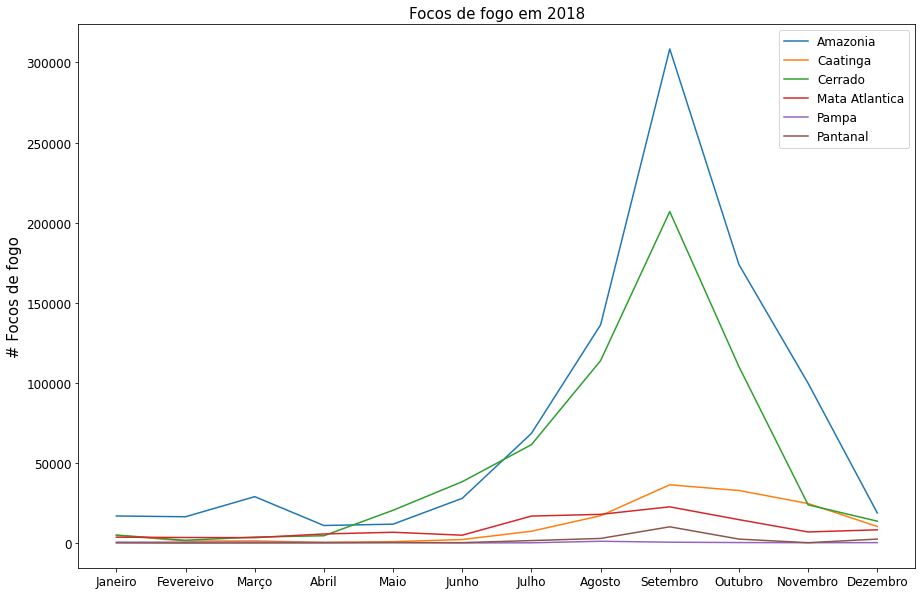

In [ ]:
plot_year(df, 2018)

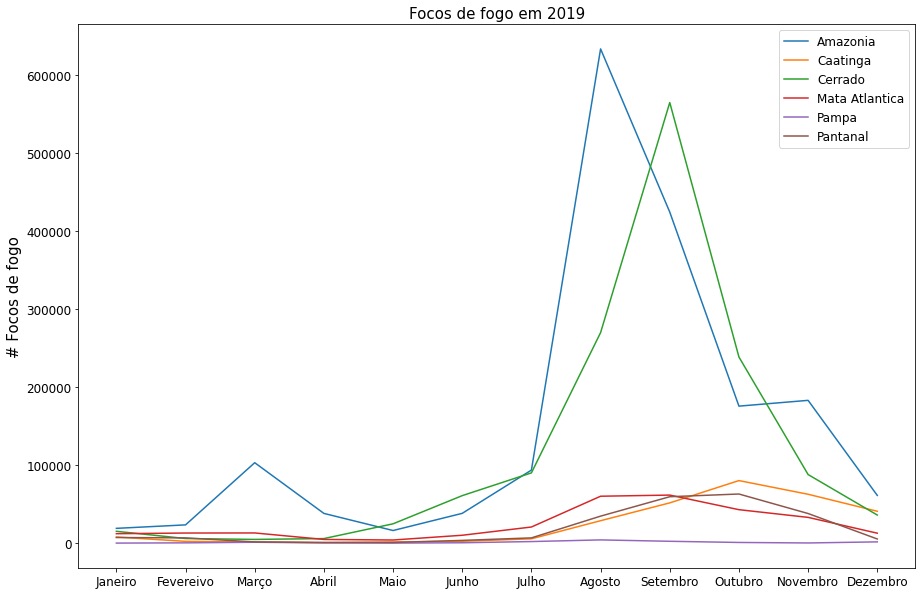

In [ ]:
plot_year(df, 2019)

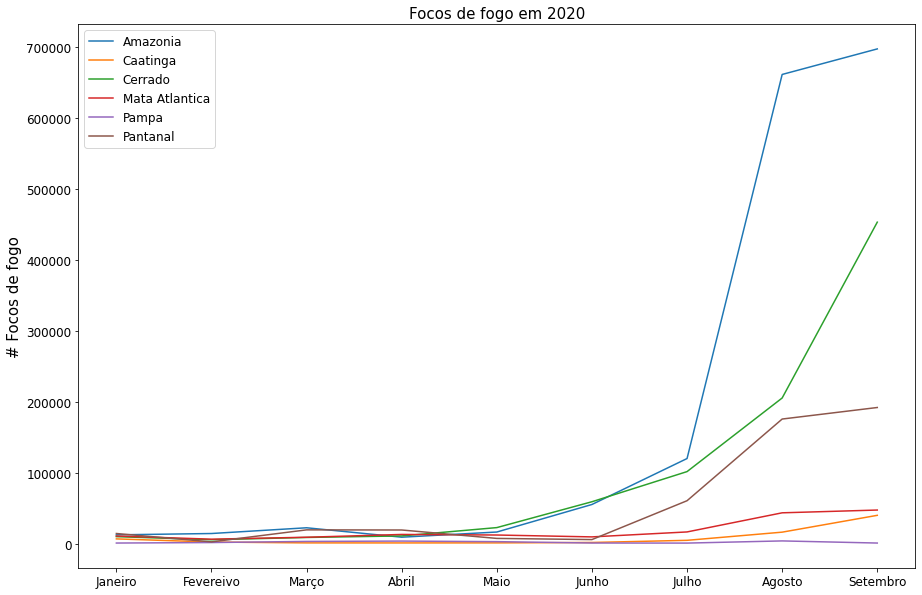

In [ ]:
plot_year(df, 2020)